In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
dicpath = '/usr/local/lib/mecab/dic/mecab-ko-dic'
tokenizer = Mecab(dicpath)
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [3]:
def load_data(train_data, test_data, num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    print(len(counter))
    #이 부분을 조정해서 가변으로 만듬
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, 20000)

53961


여기서 word_to_index의 수가 계속 10000으로 고정되어 나오는 것을 보고 함수를 뜯어봤더니 상수값으로 고정되어 있었다. 그래서 이를 가변으로 만들었다. 처음에는 3만으로 했는데 자꾸 메모리가 터져서 2만으로 줄였다. 

In [4]:
print(len(word_to_index))

20000


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [84]:
index_to_word = {index:word for word, index in word_to_index.items()}

20000

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


이제 세 모델을 비교해 볼 차례이다. 먼저 model1은 RNN을 이용한 모델이다. 

In [9]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model1 = keras.Sequential()

model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 6,009,969
Trainable params: 6,009,969
Non-trainable params: 0
_________________________________________________________________


In [10]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

모델 2는 여러 layer들을 깔아썼다.  

In [11]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 6,002,417
Trainable params: 6,002,417
Non-trainable params: 0
_________________________________________________________________


모델 3은 여러 모델 1에서 하나의 layer를 GlobalMaxPooling으로 바꿨다. 

In [12]:
# 20%는 validation 데이터로
x_val = x_train[x_train.shape[0]//2:]
y_val = y_train[y_train.shape[0]//2:]
partial_x_train = x_train[:x_train.shape[0]//2]
partial_y_train = y_train[:y_train.shape[0]//2]
print(partial_x_train.shape)
print(partial_y_train.shape)

(73091, 41)
(73091,)


In [13]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
143/143 [==============================] - 7s 48ms/step - loss: 0.5036 - accuracy: 0.7798 - val_loss: 0.3761 - val_accuracy: 0.8386
Epoch 2/10
143/143 [==============================] - 7s 46ms/step - loss: 0.3150 - accuracy: 0.8708 - val_loss: 0.3571 - val_accuracy: 0.8442
Epoch 3/10
143/143 [==============================] - 7s 46ms/step - loss: 0.2568 - accuracy: 0.8977 - val_loss: 0.3684 - val_accuracy: 0.8436
Epoch 4/10
143/143 [==============================] - 7s 46ms/step - loss: 0.2163 - accuracy: 0.9164 - val_loss: 0.3875 - val_accuracy: 0.8432
Epoch 5/10
143/143 [==============================] - 7s 46ms/step - loss: 0.1837 - accuracy: 0.9299 - val_loss: 0.4149 - val_accuracy: 0.8393
Epoch 6/10
143/143 [==============================] - 7s 46ms/step - loss: 0.1566 - accuracy: 0.9417 - val_loss: 0.4629 - val_accuracy: 0.8365
Epoch 7/10
143/143 [==============================] - 6s 45ms/step - loss: 0.1368 - accuracy: 0.9496 - val_loss: 0.4947 - val_accuracy: 0.8351

1537/1537 - 3s - loss: 0.5819 - accuracy: 0.8306
[0.5818852186203003, 0.8305633068084717]


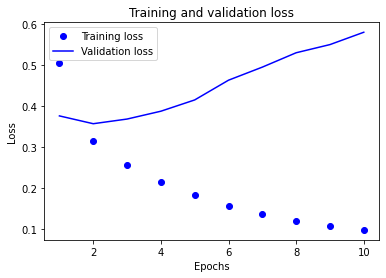

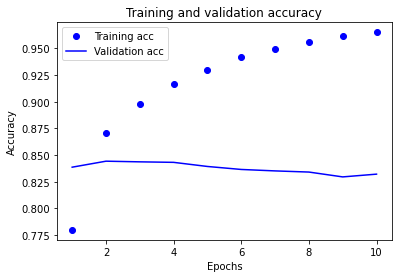

In [14]:
results = model1.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = history1.history
import matplotlib.pyplot as plt

def draw_chart(history_dict) :
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

draw_chart(history_dict)



0.83의 정확도를 나타냈다. 이제 이 정확도가 가장 높은 모델을 최종 학습 모델로 쓸 것이다. 

In [15]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
143/143 [==============================] - 12s 87ms/step - loss: 0.4839 - accuracy: 0.7549 - val_loss: 0.3622 - val_accuracy: 0.8418
Epoch 2/10
143/143 [==============================] - 7s 46ms/step - loss: 0.2925 - accuracy: 0.8807 - val_loss: 0.3555 - val_accuracy: 0.8458
Epoch 3/10
143/143 [==============================] - 7s 46ms/step - loss: 0.2074 - accuracy: 0.9228 - val_loss: 0.3785 - val_accuracy: 0.8460
Epoch 4/10
143/143 [==============================] - 7s 46ms/step - loss: 0.1306 - accuracy: 0.9561 - val_loss: 0.4499 - val_accuracy: 0.8381
Epoch 5/10
143/143 [==============================] - 7s 47ms/step - loss: 0.0779 - accuracy: 0.9762 - val_loss: 0.5220 - val_accuracy: 0.8323
Epoch 6/10
143/143 [==============================] - 7s 46ms/step - loss: 0.0478 - accuracy: 0.9861 - val_loss: 0.5924 - val_accuracy: 0.8340
Epoch 7/10
143/143 [==============================] - 7s 46ms/step - loss: 0.0310 - accuracy: 0.9909 - val_loss: 0.6695 - val_accuracy: 0.830

1537/1537 - 5s - loss: 0.8364 - accuracy: 0.8210
[0.8364234566688538, 0.8210020661354065]


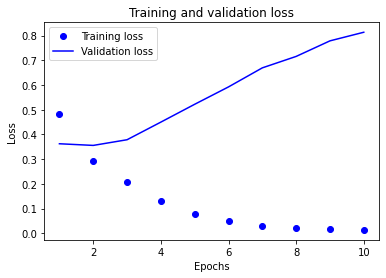

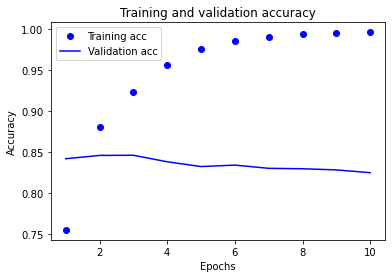

In [16]:
results = model2.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = history2.history
draw_chart(history_dict)

0.83의 정확도를 나타냈는데, 특이하게 처음에는 accuracy가 확 올랐다가 그 다음에 오버피팅이 되는 모습을 볼 수 있다. 

In [17]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
143/143 [==============================] - 7s 47ms/step - loss: 0.5246 - accuracy: 0.7799 - val_loss: 0.3816 - val_accuracy: 0.8344
Epoch 2/10
143/143 [==============================] - 7s 47ms/step - loss: 0.3174 - accuracy: 0.8695 - val_loss: 0.3501 - val_accuracy: 0.8469
Epoch 3/10
143/143 [==============================] - 7s 49ms/step - loss: 0.2441 - accuracy: 0.9046 - val_loss: 0.3558 - val_accuracy: 0.8490
Epoch 4/10
143/143 [==============================] - 7s 48ms/step - loss: 0.1862 - accuracy: 0.9311 - val_loss: 0.3754 - val_accuracy: 0.8458
Epoch 5/10
143/143 [==============================] - 7s 46ms/step - loss: 0.1370 - accuracy: 0.9545 - val_loss: 0.4061 - val_accuracy: 0.8434
Epoch 6/10
143/143 [==============================] - 7s 46ms/step - loss: 0.0969 - accuracy: 0.9721 - val_loss: 0.4401 - val_accuracy: 0.8416
Epoch 7/10
143/143 [==============================] - 7s 47ms/step - loss: 0.0657 - accuracy: 0.9833 - val_loss: 0.4783 - val_accuracy: 0.8386

1537/1537 - 2s - loss: 0.5857 - accuracy: 0.8342
[0.5857086181640625, 0.8342046737670898]


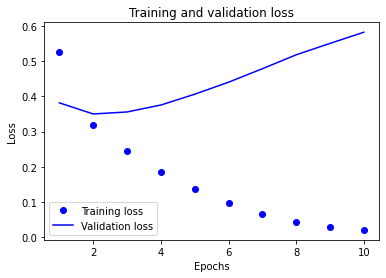

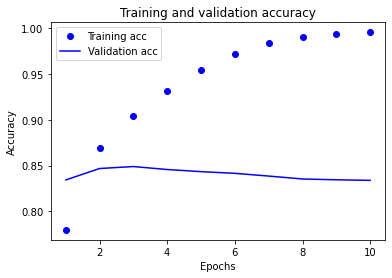

In [18]:
results = model3.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = history3.history
draw_chart(history_dict)

모델 1과 모델 3이 비슷한 수치를 보였다. 그래서 이 둘을 모두 학습에 쓰려고 한다. 

In [82]:
import gensim
from gensim.models import Word2Vec
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec2.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [19]:

ko_emb_model = gensim.models.Word2Vec.load('~/Downloads/ko.bin')
print(ko_emb_model)
vocab_size = 20000    # 어휘 사전의 크기입니다 => 아까 2만개의 단어장을 생성함
word_vector_dim = 200  # 워드 벡터의 차원수 => 깃허브에는 차원이 200이라고 나와있음

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_emb_model:
        embedding_matrix[i] = ko_emb_model[index_to_word[i]]

Word2Vec(vocab=30185, size=200, alpha=0.025)


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [62]:
ko_emb_model.wv.vectors.shape
print(ko_emb_model.wv.similarity('사람','동물'))
print(ko_emb_model.wv.most_similar('사람'))
print(ko_emb_model.wv.most_similar('동물'))

0.45262784
[('젊은이', 0.6494427919387817), ('여인', 0.6287257671356201), ('백성', 0.6063709855079651), ('포졸', 0.6043275594711304), ('죄인', 0.5960500836372375), ('선비', 0.5868039131164551), ('부녀자', 0.5654411315917969), ('죄수', 0.5639811754226685), ('구경꾼', 0.5620019435882568), ('손님', 0.5589559078216553)]
[('곤충', 0.7881758213043213), ('생물', 0.7381489276885986), ('포유류', 0.7128771543502808), ('설치류', 0.6948099136352539), ('기생충', 0.6733793616294861), ('진딧물', 0.6730732917785645), ('파충류', 0.6707451343536377), ('영장류', 0.6645059585571289), ('균류', 0.6637319326400757), ('절지', 0.6627507209777832)]
0.12902942


layer를 평가하려고 아무 단어나 골라서 쳐봤는데 도데체 뭘 학습한 건지 사람의 경우 대명사들이 학습되어있고, 동물은 종류와 종이 뒤섞여 있다. 

In [69]:
print(ko_emb_model.wv.similarity('아주','긍정'))
print(ko_emb_model.wv.similarity('아주','부정'))
print(ko_emb_model.wv.similarity('너무','긍정'))
print(ko_emb_model.wv.similarity('너무','부정'))
print(ko_emb_model.wv.most_similar('기쁨'))
print(ko_emb_model.wv.most_similar('슬픔'))

0.073823944
-0.055526674
0.05497939
0.03039897
[('즐거움', 0.7912124395370483), ('슬픔', 0.7767106294631958), ('아름다움', 0.6815950870513916), ('웃음', 0.6811692714691162), ('괴로움', 0.6798388957977295), ('행운', 0.6609852910041809), ('인생', 0.6571204662322998), ('젊음', 0.6522527933120728), ('영광', 0.6512227654457092), ('행복', 0.6493781805038452)]
[('기쁨', 0.7767106294631958), ('절망', 0.7710497379302979), ('아픔', 0.7430999279022217), ('비탄', 0.7297681570053101), ('고독', 0.725147545337677), ('사랑', 0.7216662168502808), ('외로움', 0.7195188999176025), ('추억', 0.6951202750205994), ('이별', 0.6873862743377686), ('괴로움', 0.6854110956192017)]


In [ ]:
아주와 너무에 대해서는 아주아주 근소한 차이로 긍정으로 여기는 면이 있다. 그리고 기쁨과 슬픔에 대해서는 서로 연관성이 깊다고 나와있다. 아무래도 정 반대 단어를 골라서 그렇게 나온 것 같다. 

In [21]:
from tensorflow.keras.initializers import Constant
vocab_size = 20000   
word_vector_dim = 200 
ko_model = keras.Sequential()
ko_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
ko_model.add(keras.layers.GlobalMaxPooling1D())
ko_model.add(keras.layers.Dense(8, activation='relu'))
ko_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

ko_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           4000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 4,001,617
Trainable params: 4,001,617
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
143/143 [==============================] - 5s 33ms/step - loss: 0.6824 - accuracy: 0.5588 - val_loss: 0.6499 - val_accuracy: 0.6272
Epoch 2/20
143/143 [==============================] - 4s 31ms/step - loss: 0.5988 - accuracy: 0.6781 - val_loss: 0.5703 - val_accuracy: 0.7039
Epoch 3/20
143/143 [==============================] - 4s 31ms/step - loss: 0.5313 - accuracy: 0.7361 - val_loss: 0.5228 - val_accuracy: 0.7393
Epoch 4/20
143/143 [==============================] - 4s 31ms/step - loss: 0.4855 - accuracy: 0.7672 - val_loss: 0.4996 - val_accuracy: 0.7551
Epoch 5/20
143/143 [==============================] - 5s 32ms/step - loss: 0.4511 - accuracy: 0.7892 - val_loss: 0.4737 - val_accuracy: 0.7732
Epoch 6/20
143/143 [==============================] - 4s 31ms/step - loss: 0.4220 - accuracy: 0.8064 - val_loss: 0.4735 - val_accuracy: 0.7708
Epoch 7/20
143/143 [==============================] - 4s 30ms/step - loss: 0.3974 - accuracy: 0.8220 - val_loss: 0.4494 - val_accuracy: 0.7889

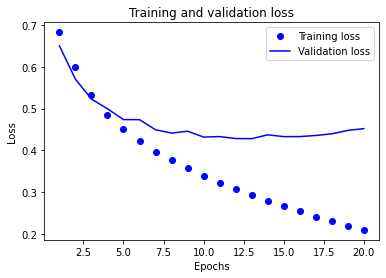

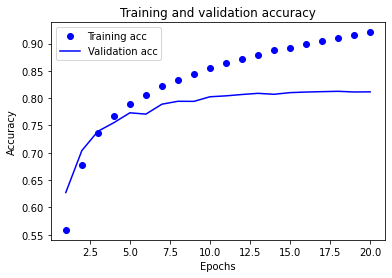

In [22]:
ko_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

ko_history = ko_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results = ko_model.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = ko_history.history

draw_chart(history_dict)

학습은 모델 3을 가지고 진행했다. 15회 학습 전후에서 validation의 loss값이 증가하는 것을 볼 수 있다. 정확도는 0.81

In [23]:
ko_emb_model2 = gensim.models.Word2Vec.load('/home/aiffel/Downloads/word-embeddings/word2vec/word2vec')
print(ko_emb_model2)

Word2Vec(vocab=358043, size=100, alpha=0.025)


해당 임베딩은 `https://ratsgo.github.io/embedding/` 에서 가져온 것이다. 미리 형태소 분석에 학습까지 마친 데이터이다. 담고 있는 데이터는 한국어 위키백과 + 한국어 위키백과를 바탕으로 질의문답을 던진 그 결과이다.(출처 : `https://www.slideshare.net/LGCNSairesearch/korquad-v20?ref=https://www.slideshare.net/LGCNSairesearch/slideshelf`) 크기가 35만에 달한다. 차원수는 100. 

In [63]:
print(ko_emb_model2.wv.similarity('사람','동물'))
print(ko_emb_model2.wv.most_similar('사람'))
print(ko_emb_model2.wv.most_similar('동물'))

0.42152
[('것', 0.7147731781005859), ('년놈', 0.6873180866241455), ('자', 0.6854001879692078), ('인물', 0.6784037351608276), ('놈', 0.6638504266738892), ('볼까봐', 0.6515195369720459), ('추율', 0.6507209539413452), ('건', 0.6464706659317017), ('모리배', 0.6451746225357056), ('해줘도', 0.6447634696960449)]
[('곤충', 0.7645733952522278), ('애완', 0.7520819902420044), ('침팬지', 0.7501280307769775), ('애완곤충', 0.7449706792831421), ('고양이', 0.7405434250831604), ('유선형동물', 0.7384648323059082), ('야생', 0.7299400568008423), ('무척추', 0.7217742204666138), ('생물', 0.7212396860122681), ('고양잇과', 0.7208222150802612)]


위의 임베딩을 테스트하려고 똑같은 단어를 넣었더니 아주 다른 결과가 나왔다. 해당 임베딩의 출처로 미뤄보아 질의응답의 결과에 따라 임베딩의 결과가 많이 영향을 받았음을 알 수 있다. 

In [67]:
print(ko_emb_model2.wv.similarity('아주','긍정'))
print(ko_emb_model2.wv.similarity('아주','부정'))
print(ko_emb_model2.wv.similarity('너무','긍정'))
print(ko_emb_model2.wv.similarity('너무','부정'))
print(ko_emb_model2.wv.most_similar('기쁨'))
print(ko_emb_model2.wv.most_similar('슬픔'))

0.39502907
0.33241543
0.5081686
0.3687183
[('즐거움', 0.8311127424240112), ('희열', 0.7585986852645874), ('슬픔', 0.7448212504386902), ('행복', 0.7309410572052002), ('소망', 0.7156158685684204), ('마음', 0.713006854057312), ('삶', 0.7120159864425659), ('희노애락', 0.7119839191436768), ('아픔', 0.7082540988922119), ('해방감', 0.7070746421813965)]
[('외로움', 0.8247721195220947), ('아픔', 0.806294322013855), ('슬픈', 0.80266273021698), ('그리움', 0.7921730279922485), ('마음', 0.778411865234375), ('서글픈', 0.7769325971603394), ('쓸쓸', 0.762446939945221), ('상실감', 0.7595953345298767), ('눈물', 0.7561120986938477), ('절망감', 0.7485480904579163)]


이번에는 감정에 대해서 테스트해봤다. 앞에 붙는 부사로 테스트해보았는데, 아주와 너무를 둘다 긍정으로 판단하는 경향이 있다. 
그리고 기쁨과 그 반대인 슬픔을 테스트해 봤는데, 기쁨에 슬픔이 0.74로 매우 가깝게 나와서 의외이다. 혹시 학습한 데이터가 한국인의 한에 대한 문서인가. 

In [24]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 => 깃허브에는 차원이 200이라고 나와있음

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_emb_model2:
        embedding_matrix[i] = ko_emb_model2[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,000,817
Trainable params: 2,000,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
143/143 [==============================] - 2s 16ms/step - loss: 0.6644 - accuracy: 0.6219 - val_loss: 0.6115 - val_accuracy: 0.7287
Epoch 2/20
143/143 [==============================] - 2s 16ms/step - loss: 0.5269 - accuracy: 0.773

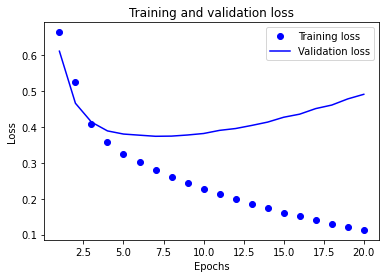

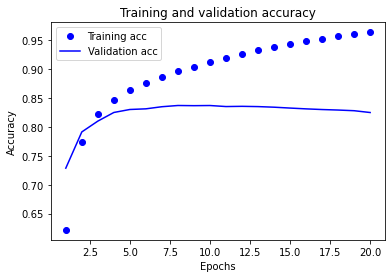

In [25]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
ko_model2 = keras.Sequential()
ko_model2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
ko_model2.add(keras.layers.GlobalMaxPooling1D())
ko_model2.add(keras.layers.Dense(8, activation='relu'))
ko_model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

ko_model2.summary()

ko_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

ko_history = ko_model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results = ko_model2.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = ko_history.history

draw_chart(history_dict)

모델 3번을 가지고 다시 실험했다. 정확도는 0.82

이번에는 모델 1번을 가지고 학습했다. 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,003,569
Trainable params: 2,003,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
143/143 [==============================] - 3s 19ms/step - loss: 0.5276 - accuracy: 0.7423 - val_loss: 0.4086 - val_accuracy: 0.8183
Epoch 2/5
143/143 [==============================] - 3s 18ms/step - loss: 0.3562 - accuracy: 0.8490 

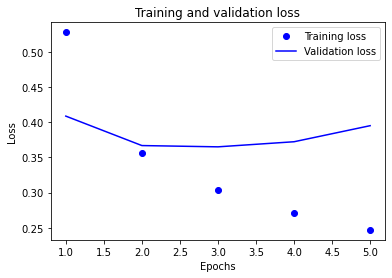

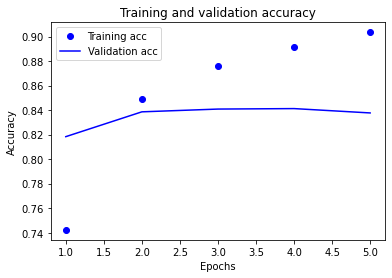

In [27]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
ko_model3 = keras.Sequential()

ko_model3.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
ko_model3.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
ko_model3.add(keras.layers.Dense(8, activation='relu'))
ko_model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

ko_model3.summary()

ko_model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

ko_history = ko_model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results = ko_model3.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = ko_history.history

draw_chart(history_dict)

모델 1번은 정확도 0.83을 보여주었다. 그런데 초반에 validation에서 정확도가 가파르게 오르다가 어느 시점에서 정확도가 낮아지는 것을 볼 수 있다. 그렇다면 gradient descent가 너무 급격하게 이루어 진 것은 아닐까? 그래서 optimization을 바꿔보았다. adam은 adam인데 제일 최근에 구현된 Nadam을 골라보았고(출처 : `http://blog.naver.com/PostView.nhn?blogId=dnjswns2280&logNo=221904217282&parentCategoryNo=&categoryNo=7&viewDate=&isShowPopularPosts=true&from=search`), 그리고 callback함수를 통해서 best 모델을 잡아낼 수 있게 만들었다. 3회정도 loss에 변화가 일어날 때 학습을 중단하도록 만들었다.

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 41, 100)           2000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 2,003,569
Trainable params: 2,003,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
143/143 [==============================] - 2s 16ms/step - loss: 0.5219 - accuracy: 0.7379 - val_loss: 0.4054 - val_accuracy: 0.8221
Epoch 2/10
143/143 [==============================] - 2s 15ms/step - loss: 0.3646 - accuracy: 0.84

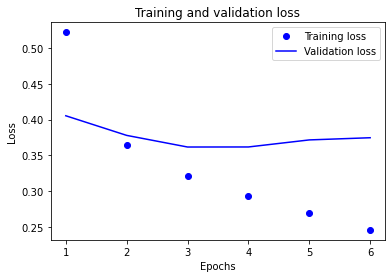

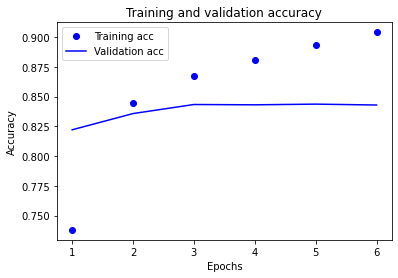

In [37]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
ko_model4 = keras.Sequential()

ko_model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
ko_model4.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
ko_model4.add(keras.layers.Dense(8, activation='relu'))
ko_model4.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

ko_model4.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

ko_model4.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

ko_history = ko_model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es, mc])
results = ko_model4.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = ko_history.history

draw_chart(history_dict)

결과는 0.84로 더 올랐다. 그렇다면 RNN의 vector 차원을 늘려볼까. 시험삼아서 2배씩 늘려보았다.

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 41, 100)           2000000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               365568    
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 2,367,633
Trainable params: 2,367,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
143/143 [==============================] - 4s 30ms/step - loss: 0.5055 - accuracy: 0.7529 - val_loss: 0.3948 - val_accuracy: 0.8253
Epoch 2/10
143/143 [==============================] - 4s 28ms/step - loss: 0.3634 - accuracy: 0.84

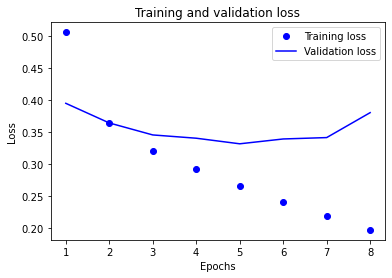

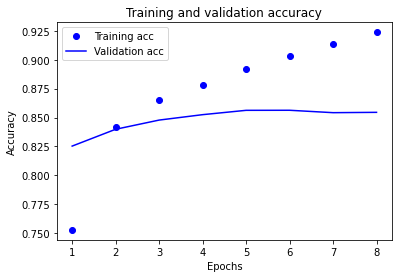

In [42]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
ko_model5 = keras.Sequential()

ko_model5.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
ko_model5.add(keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
ko_model5.add(keras.layers.Dense(8, activation='relu'))
ko_model5.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

ko_model5.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

ko_model5.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

ko_history = ko_model5.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es, mc])
results = ko_model5.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = ko_history.history

draw_chart(history_dict)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 41, 100)           2000000   
_________________________________________________________________
gru_5 (GRU)                  (None, 256)               274944    
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 9         
Total params: 2,277,009
Trainable params: 2,277,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
143/143 [==============================] - 4s 27ms/step - loss: 0.4796 - accuracy: 0.7642 - val_loss: 0.3852 - val_accuracy: 0.8255
Epoch 2/10
143/143 [==============================] - 4s 25ms/step - loss: 0.3490 - accuracy: 0.84

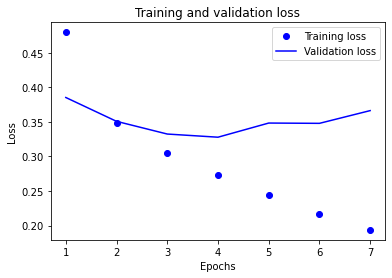

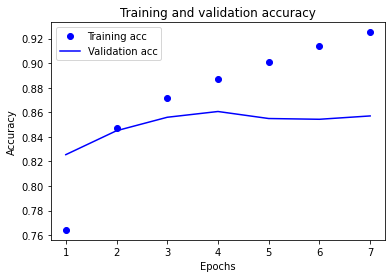

In [48]:
vocab_size = 20000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
ko_model6 = keras.Sequential()

ko_model6.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
ko_model6.add(keras.layers.GRU(256))   # 찾아보니 GRU라는 것도 있다고 해서 한번 써봤다. 
ko_model6.add(keras.layers.Dense(8, activation='relu'))
ko_model6.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

ko_model6.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

ko_model6.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

ko_history = ko_model6.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es, mc])
results = ko_model6.evaluate(x_test,  y_test, verbose=2)

print(results)

history_dict = ko_history.history

draw_chart(history_dict)

RNN의 cell수를 늘리는 것이 vector size와 연관있다고 찾았다. (출처 : `https://davinci-ai.tistory.com/30`) 여기서 RNN의 단점을 극복할 방법 2가지를 제안했는데, 하나는 LSTM이고 나머지는 GRU였다. 그래서 GRU도 궁금해서 써봤다. 벡터값은 8로 시작해서 256까지 늘려보았다. 최종 결과값은 0.8537로 정확도가 소폭 증가했다. 

#### 회고

이번 노드의 핵심은 hyperparameter의 조절이 아닐까. 그리고 단어장에 단어수가 많다고 해서 좋은 건 아니다. 단어장을 3만개로 만들었을때 정확도에는 거의 변화가 없었고 중간에 메모리가 부족해서 나가떨어졌기 때문이다. 그리고 RNN을 쓸 때는 gradient descent 방식을 잘 선택해야 오버피팅이 되는 것을 막을 수 있을 것이다. 